# Data loading

In [1]:
import sys
sys.path.insert(0, "../..")

In [2]:
import os
import numpy as np
import scipy.io

In [3]:
data_path = "./exp03_pds.mat"
data_mat = scipy.io.loadmat(data_path)
data = data_mat["pds"]

print(f"Data shape: {data.shape}")

Data shape: (1, 19)


In [4]:
data = data.ravel()

y = []
for label, diagram in enumerate(data):
    diagram = diagram.ravel()
    y += len(diagram) * [label]
y = np.array(y)

X = np.concatenate(data)
X = np.concatenate(X)

In [5]:
splits_path = "./geomat_splits.mat"
splits_mat = scipy.io.loadmat(splits_path)
trainSets = splits_mat["trainSet"].ravel() - 1
testSets = splits_mat["testSet"].ravel() - 1

premade_splits = np.array([np.array((testSet.ravel(), trainSet.ravel())) 
                           for testSet, trainSet in zip(trainSets, testSets)])

# Model comparison
## First step: Model hyperparameter optimization

In [6]:
import joblib
import pandas as pd

from preprocessing import *
from persistent_bow import *
from visualization import *
from experiments.utils import *

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC, LinearSVC
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler

from gudhi.representations.preprocessing import BirthPersistenceTransform, DiagramScaler
from gudhi.representations.kernel_methods import SlicedWassersteinKernel
from gudhi.representations.vector_methods import PersistenceImage
from gudhi.representations.metrics import BottleneckDistance

#Fast hack to make SlicedWassersteinKernel scikit-compliant
setattr(SlicedWassersteinKernel, "get_params",
        lambda self, deep: {
            "bandwidth":self.bandwidth,
            "num_directions" : self.sw_.num_directions
        })

In [7]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
fold = StratifiedKFold(5, shuffle=True, random_state=42)
splits = premade_splits#np.array([split for split in fold.split(X, y)])

In [8]:
#Helper function, constructs final pipeline and returns girdsearch for it
def make_final_grid(estimator, param_grid, kernel="linear", *args, **kwargs ):
    new_param_grid = {f"Model__{name}" : values for name, values in param_grid.items()}
    new_param_grid["Predictor__C"] = [0.1, 1, 10]
    
    final_pipeline = Pipeline([
        ("Model", estimator),
        ("Predictor", SVC(kernel=kernel, max_iter=1e4))
    ])
    
    return GridSearchCV(final_pipeline, new_param_grid, cv = splits, *args, **kwargs)

In [9]:
# Weight functions

def const(x):
    return 1

def linear(x):
    return x[1]

def pow2(x):
    return x[1]**2

In [10]:
#PBoW gridsearch
pbow_gridsearch = make_final_grid(
    estimator = PersistentBow(KMeans(7, n_init=1, max_iter=100, random_state=42),
                              sampler=RandomPDSampler(2500, random_state=42),
                              scaler=DiagramScaler(use=True, 
                                                   scalers=[
                                                      ((0,), MinMaxScaler(copy=False)),
                                                      ((1,), MinMaxScaler(copy=False))])),
    param_grid = {
        "cluster__n_clusters" : np.arange(10, 200, 10),
        "sampler__max_points" : np.arange(1000, 13000, 1000),
        "sampler__weight_function" : [const, linear, pow2]
    },
    n_jobs = -1
)

#SPBoW gridsearch
spbow_gridsearch = make_final_grid(
    estimator = StablePersistentBow(GaussianMixture(random_state=42),
                              sampler=RandomPDSampler(2500, random_state=42)),
    param_grid = {
        "mixture__n_components" : np.arange(10, 200, 10),
        "sampler__max_points" : np.arange(1000, 13000, 1000),
        "sampler__weight_function" : [const, linear, pow2]
    },
    n_jobs = -1
)

# PBOW with KMeans from VLFeat # TODO: This is Vl kmeans are 2 functions only
# We need to wrap it with something what fits fit, transform API
# pbow_on_stereoids = pbow_pipeline = Pipeline([
#     ("pbow",  PersistentBow(Vlkmeans(7,2), sampler=RandomPDSampler(2500)))
# ])


#SlicedWassersteinKernel gridsearch (without using it as kernel)
swk_gridsearch = make_final_grid(
    estimator = SlicedWassersteinKernel(),
    param_grid = {
        "bandwidth" : [0.05, 0.1, 0.25, 0.5, 1, 1.5, 2],
        "num_directions" : [5, 10, 15, 20, 25]
    },
    n_jobs = -1    
)

#SlicedWassersteinKernel gridsearch (using it as kernel)
swk_ker_gridsearch = make_final_grid(
    estimator = SlicedWassersteinKernel(),
    param_grid = {
        "bandwidth" : [0.05, 0.1, 0.25, 0.5, 1, 1.5, 2],
        "num_directions" : [5, 10, 15, 20, 25]
    },
    kernel="precomputed",
    n_jobs = -1
)

#BottleneckDistance gridsearch
bd_gridsearch = make_final_grid(
    estimator = BottleneckDistance(),
    param_grid = {
        "epsilon" : [1e-8, None]
    },
    n_jobs = -1  
)

#PersistenceImage gridsearch
pi_gridsearch = make_final_grid(
    estimator = PersistenceImage(),
    param_grid = {
        "bandwidth" : [0.1, 0.25, 0.5, 1, 1.5],
        "weight" : [const, linear, pow2],
        "resolution" : [(10,10), (20,20), (40,40), (50, 50)],
    },
    n_jobs = -1
)

models_to_test = {
    "PBoW" : pbow_gridsearch, 
    "SPboW" : spbow_gridsearch,
    #"SWK" : swk_gridsearch, 
    #"SWK_ker" : swk_ker_gridsearch,
    #"Bottleneck" : bd_gridsearch,
    "PersistenceImage" : pi_gridsearch
}

In [11]:
for name, grid in models_to_test.items():
    print(name)
    grid_path = f"precomputed/grid/{name}.dill"
    
    out = load(grid_path)
    if out:
        print("Loaded from file")
        models_to_test[name] = out
    else:
        grid.verbose = 10
        grid.fit(X, y)
        save(grid, grid_path)

PBoW
Loaded from file
SPboW
Loaded from file
PersistenceImage
Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 120 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:  4.8min
/home/drenda/miniconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed: 25.4min
[Parallel(n_jobs=-1)]: Done 125 tasks      | elapsed: 49.7min
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed: 52.3min
[Parallel(n_jobs=-1)]: Done 181 tasks      | elapsed: 53.4min
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed: 53.7min
[Parallel(n_jobs=-1)]: Done 241 tasks      | elapsed: 53.7min
[Parallel(n_j

## Comparison of best estimators

In [12]:
#Grid computation
grid_path = "precomputed/grid"
cv_path = "precomputed/cv"

for filename in os.listdir(grid_path):
    name = os.path.splitext(filename)[0]
    grid = load(os.path.join(grid_path, filename))
    results = load(os.path.join(cv_path, filename))
    
    if not results:
        print("Computing", name)
        model = grid.best_estimator_
        results = cross_validate(model, X, y, cv=splits, n_jobs=-1, verbose=10)
        save(results, os.path.join(cv_path, f"{name}.dill"))
    

Computing PersistenceImage


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 120 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.8min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 120 concurrent workers.


Computing SPboW


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   13.8s remaining:   20.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   15.1s remaining:   10.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 120 concurrent workers.


Computing PBoW


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.3s remaining:   12.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   10.0s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.2s finished


In [13]:
#Final crossval score computation
grid_path = "precomputed/grid"
cv_path = "precomputed/cv"

for filename in os.listdir(grid_path):
    name = os.path.splitext(filename)[0]
    grid = load(os.path.join(grid_path, filename))
    results = load(os.path.join(cv_path, filename))
    
    if not results:
        print("Computing", name)
        model = grid.best_estimator_
        results = cross_validate(model, X, y, cv=splits)
        save(results, os.path.join(cv_path, f"{name}.dill"))
    

In [14]:
#Printing scores
base_path = "precomputed/cv"
for filename in os.listdir(base_path):
    path = os.path.join(base_path, filename)
    name = os.path.splitext(filename)[0]
    
    results = load(path)
    print(name, "Mean scores:")
    df = pd.DataFrame(results)
    print(df.mean(), "\n")

SPboW Mean scores:
fit_time      4.949170
score_time    0.939057
test_score    0.248421
dtype: float64 

PersistenceImage Mean scores:
fit_time      23.390421
score_time    10.036189
test_score     0.112632
dtype: float64 

PBoW Mean scores:
fit_time      0.964102
score_time    0.179233
test_score    0.229474
dtype: float64 



## Listing  of best parameters for each model

In [15]:
for name, grid in models_to_test.items():
    print(name, "Best parameters:")
    grid_params = grid.param_grid.keys()
    model = grid.best_estimator_
    for param_name in grid_params:
        param = model.get_params()[param_name]
        print(f'{param_name} :', param)
    print()

PBoW Best parameters:
Model__cluster__n_clusters : 50
Model__sampler__max_points : 6000
Model__sampler__weight_function : <function const at 0x7f31805abc20>
Predictor__C : 0.1

SPboW Best parameters:
Model__mixture__n_components : 70
Model__sampler__max_points : 9000
Model__sampler__weight_function : <function pow2 at 0x7f31805ab3b0>
Predictor__C : 10

PersistenceImage Best parameters:
Model__bandwidth : 0.1
Model__weight : <function const at 0x7f306f26aef0>
Model__resolution : (40, 40)
Predictor__C : 0.1



## Plot - PBoW accuracy vs n_clusters

10 35 60 85 110 135 160 185 210 235 260 285 310 335 360 385 

Text(0.5, 1.0, 'Accuracy vs number of components')

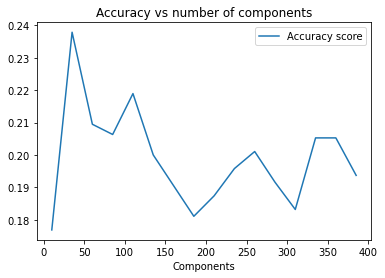

In [16]:
best_max_points = models_to_test["PBoW"].best_params_["Model__sampler__max_points"] + 2000
best_n_clusters = models_to_test["PBoW"].best_params_["Model__cluster__n_clusters"]
best_weight = models_to_test["PBoW"].best_params_["Model__sampler__weight_function"]
best_C = models_to_test["PBoW"].best_params_["Predictor__C"]

result_list = []
n_clusters_range = np.arange(10, 400, 25)
for n_clusters in n_clusters_range:
    print(n_clusters, end = " ")
    final_pipeline = Pipeline([
        ("pbow",  PersistentBow(KMeans(n_clusters, n_init=5, max_iter=300, random_state=42),
                                sampler=RandomPDSampler(best_max_points, best_weight, random_state=42))),
        ("Predictor", SVC(kernel="linear",C = best_C))
    ])
    
    results = cross_val_score(final_pipeline, X, y, cv=splits)
    result_list.append(np.mean(results))
    
plt.plot(n_clusters_range, result_list, label="Accuracy score")
plt.xlabel("Components")
plt.legend()
plt.title("Accuracy vs number of components")

## Plot - PBoW accuracy vs sampler max_points

Text(0.5, 1.0, 'Accuracy vs max_points')

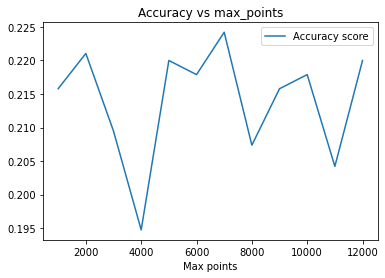

In [17]:
best_max_points = models_to_test["PBoW"].best_params_["Model__sampler__max_points"]
best_n_clusters = models_to_test["PBoW"].best_params_["Model__cluster__n_clusters"]
best_weight = models_to_test["PBoW"].best_params_["Model__sampler__weight_function"]
best_C = models_to_test["PBoW"].best_params_["Predictor__C"]

result_list = []
max_points_range = np.arange(1000, 13000, 1000)
for max_points in max_points_range:
    final_pipeline = Pipeline([
        ("pbow",  PersistentBow(KMeans(best_n_clusters, n_init=1, max_iter=100, random_state=42), 
                                sampler=RandomPDSampler(max_points, best_weight, random_state=42))),
        ("Predictor", SVC(kernel="linear", C=best_C))
    ])
    
    results = cross_val_score(final_pipeline, X, y, cv=splits, n_jobs=-1)
    result_list.append(np.mean(results))
    
plt.plot(max_points_range, result_list, label="Accuracy score")
plt.xlabel("Max points")
plt.legend()
plt.title("Accuracy vs max_points")